# Assignment #3
## P556: Applied Machine Learning

More often than not, we will use a deep learning library (Tensorflow, Pytorch, or the wrapper known as Keras) to implement our models. However, the abstraction afforded by those libraries can make it hard to troubleshoot issues if we don't understand what is going on under the hood. In this assignment you will implement a fully-connected and a convolutional neural network from scratch. To simplify the implementation, we are asking you to implement static architectures, but you are free to support variable number of layers/neurons/activations/optimizers/etc. We recommend that you make use of private methods so you can easily troubleshoot small parts of your model as you develop them, instead of trying to figure out which parts are not working correctly after implementing everything. Also, keep in mind that there is code from your fully-connected neural network that can be re-used on the CNN. 

Problem #1.1 (40 points): Implement a fully-connected neural network from scratch. The neural network will have the following architecture:

- Input layer
- Dense hidden layer with 512 neurons, using relu as the activation function
- Dropout with a value of 0.2
- Dense hidden layer with 512 neurons, using relu as the activation function
- Dropout with a value of 0.2
- Output layer, using softmax as the activation function

The model will use categorical crossentropy as its loss function. 
We will optimize the gradient descent using RMSProp, with a learning rate of 0.001 and a rho value of 0.9.
We will evaluate the model using accuracy.

Why this architecture? We are trying to reproduce from scratch the following [example from the Keras documentation](https://keras.io/examples/mnist_mlp/). This means that you can compare your results by running the Keras code provided above to see if you are on the right track.

**Imports**

In [0]:
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import time
import math

In [0]:
class Linear(object):
  def __init__(self,input_nodes, output_nodes, activation, dropout):
    
    self.input_nodes = input_nodes
    self.output_nodes = output_nodes
    self.activation = activation
    self.W = np.random.rand(self.input_nodes, self.output_nodes) * np.sqrt(2/self.input_nodes) # He initialization
    self.B = np.zeros(( 1, self.output_nodes)) 
    self.s_W = np.zeros((self.input_nodes, self.output_nodes))
    self.s_B = np.zeros((1, self.output_nodes))
    self.dropout = dropout

  def layer(self, X):

    self.X = X
    self.Z = np.dot(self.X, self.W) + self.B
    self.A = self.activation(self.Z)
    # return W, Z, A
  
  def compute_drop(self):

    ## Dropout implementation from here - https://rohanvarma.me/Neural-Net/

    self.keep_p = 1-self.dropout
    mult = np.random.binomial(1, self.keep_p, size = (1, self.output_nodes))
    self.A = self.A/self.keep_p
    self.A *= mult


In [0]:
class NeuralNetwork(object):
  def __init__(self, epochs, learning_rate, dropout, rho):
    # network parameters go here
    self.epochs = epochs
    self.learning_rate = learning_rate
    self.rho = rho
    
    # define the network here
    self.l1 = Linear(784, 512, ReLU, dropout)
    self.l2 = Linear(512, 512, ReLU, dropout)
    self.l3 = Linear(512, 10, softmax, 0)
  
  def forward_pass(self, X_test = np.array([None])):
    if X_test.all() == None:
      input_X = self.X
    else:
      input_X = X_test
    self.l1.layer(input_X)
    self.l1.compute_drop()
    self.l2.layer(self.l1.A)
    self.l2.compute_drop()
    self.l3.layer(self.l2.A)
    self.output = self.l3.A

  def correct_predictions(self, actuals = np.array([None])):
    if actuals.all() == None:
      actuals = self.y
    correct_pred = sum(np.argmax(self.l3.A, axis=1) == np.argmax(actuals, axis = 1))
    return correct_pred

  def calculate_loss(self):
    log_likelihood = -self.y* np.log(self.output)
    loss = np.sum(log_likelihood)/len(self.y)
    self.loss = loss
    return loss

  def backward_pass(self):

    m = self.X.shape[0]

    derv_Z3_wrt_W3 = self.l2.A
    derv_loss_wrt_Z3 = self.l3.A - self.y
    self.grad_W3 = 1/m * (np.dot(derv_Z3_wrt_W3.T, derv_loss_wrt_Z3))
    self.grad_B3 = 1/m * (np.dot(np.ones((1, m)), derv_loss_wrt_Z3))

    derv_Z2_wrt_W2 = self.l1.A
    derv_A2_wrt_Z2 = (self.l2.Z > 0).astype('int')
    derv_loss_wrt_A2 = np.dot(derv_loss_wrt_Z3, self.l3.W.T)

    self.grad_W2 = 1/m * (np.dot(derv_Z2_wrt_W2.T, derv_loss_wrt_A2 * derv_A2_wrt_Z2))
    self.grad_B2 = 1/m * (np.dot(np.ones((1, m)), derv_loss_wrt_A2 * derv_A2_wrt_Z2)) 

    derv_Z1_wrt_W1 = self.l1.X
    derv_A1_wrt_Z1 = (self.l1.Z > 0).astype('int')
    derv_loss_wrt_A1 = np.dot(derv_loss_wrt_A2 * derv_A2_wrt_Z2 , self.l2.W.T)

    self.grad_W1 = 1/m * (np.dot(derv_Z1_wrt_W1.T, derv_loss_wrt_A1 * derv_A1_wrt_Z1))
    self.grad_B1 = 1/m * (np.dot(np.ones((1, m)), derv_loss_wrt_A1 * derv_A1_wrt_Z1))
    
  def update_weights_bias(self):
    self.l1.W -= self.learning_rate * self.grad_W1
    self.l1.B -= self.learning_rate * self.grad_B1
    self.l2.W -= self.learning_rate * self.grad_W2
    self.l2.B -= self.learning_rate * self.grad_B2
    self.l3.W -= self.learning_rate * self.grad_W3
    self.l3.B -= self.learning_rate * self.grad_B3

  def calculate_gradient_velocities(self):
    self.l1.s_W = self.rho * self.l1.s_W + (1-self.rho) * (self.grad_W1**2)
    self.l2.s_W = self.rho * self.l2.s_W + (1-self.rho) * (self.grad_W2**2)
    self.l3.s_W = self.rho * self.l3.s_W + (1-self.rho) * (self.grad_W3**2)
    
    self.l1.s_B = self.rho * self.l1.s_B + (1-self.rho) * (self.grad_B1**2)
    self.l2.s_B = self.rho * self.l2.s_B + (1-self.rho) * (self.grad_B2**2)
    self.l3.s_B = self.rho * self.l3.s_B + (1-self.rho) * (self.grad_B3**2)

  def update_weights_bias_RMSProp(self):
    epsilon = 0.00000001

    self.calculate_gradient_velocities()
    self.l1.W -= self.learning_rate * (self.grad_W1/(np.sqrt(self.l1.s_W)+epsilon))
    self.l1.B -= self.learning_rate * (self.grad_B1/(np.sqrt(self.l1.s_B)+epsilon))
    self.l2.W -= self.learning_rate * (self.grad_W2/(np.sqrt(self.l2.s_W)+epsilon))
    self.l2.B -= self.learning_rate * (self.grad_B2/(np.sqrt(self.l2.s_B)+epsilon))
    self.l3.W -= self.learning_rate * (self.grad_W3/(np.sqrt(self.l3.s_W)+epsilon))
    self.l3.B -= self.learning_rate * (self.grad_B3/(np.sqrt(self.l3.s_B)+epsilon))
    pass


  def fit(self, X, y, batch_size):
    X, y = shuffle(X, y, random_state=0)
    for epoch in range(self.epochs):
      loss = 0
      correct = 0
      for i in range(0, X.shape[0], batch_size):
        self.X = X[i:i + batch_size] # mini batch
        self.y = y[i:i + batch_size]
        self.forward_pass()
        loss_epoch =  self.calculate_loss()
        loss += loss_epoch
        correct += self.correct_predictions()
        self.backward_pass()
        #self.update_weights_bias() # Gradient Descent
        self.update_weights_bias_RMSProp() # RMSProp
      print('Epoch', epoch, '======= Loss', loss, '======== Accuracy', \
            round((correct/X.shape[0])*100,2))
    print('\nAccuracy on Train set after',self.epochs,'epochs :',round((correct/X.shape[0])*100,2))
    pass
   
  def evaluate(self, X_test, y_test):
    self.forward_pass(X_test)
    correct = self.correct_predictions(y_test)
    return correct




**Activation Functions**

In [0]:
## RELU
f = lambda x: x if x > 0 else 0
ReLU = np.vectorize(f)

## Softmax
def softmax_helper(x):
    """Compute softmax values for each sets of scores in x."""
    epsilon = 0.000000001
    e_x = np.exp(x - np.max(x)) + epsilon
    # e_x = np.exp(x / x.max())
    return e_x / (e_x.sum())
def softmax(x):
    return np.array(list(map(softmax_helper,x)))

Problem #1.2 (10 points): Train your fully-connected neural network on the Fashion-MNIST dataset using 5-fold cross validation. Report accuracy on the folds, as well as on the test set.

**Load the data**

In [0]:
# To simplify the usage of our dataset, we will be importing it from the Keras 
# library. Keras can be installed using pip: python -m pip install keras

# Original source for the dataset:
# https://github.com/zalandoresearch/fashion-mnist

# Reference to the Fashion-MNIST's Keras function: 
# https://keras.io/datasets/#fashion-mnist-database-of-fashion-articles

import keras
from keras.datasets import fashion_mnist

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

x_train = X_train.reshape(60000, 784)
x_test = X_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
num_classes = 10
y_train = keras.utils.to_categorical(Y_train, num_classes)
y_test = keras.utils.to_categorical(Y_test, num_classes)

Using TensorFlow backend.


4423680/4422102 [==============================] - 0s 0us/step
60000 train samples
10000 test samples


**Visualize the data**

<function matplotlib.pyplot.show>

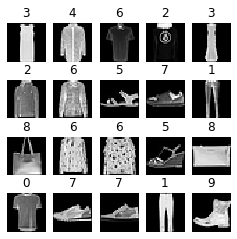

In [0]:
n_images = 20
p = np.random.permutation(len(X_train))[:n_images]

random_images = X_train[p]
random_labels = Y_train[p]
fig = plt.figure(figsize=(4,4))
for i in range(n_images):
  fig.add_subplot(n_images//5,5,i+1)
  plt.axis('off')
  plt.imshow(random_images[i], cmap = 'gray')
  plt.title(random_labels[i])
plt.show

**Training**

In [0]:
epochs = 20
lr = 0.001
drop_out = 0.2
rho = 0.9
batch_size = 200


**K-Fold Cross Validation**

In [0]:
X = x_train
y = y_train

kf = KFold(n_splits=5)
fold = 1
accuracies = []
for train_index, val_index in kf.split(X):
  print("\n### Fold:", fold,'###')
  X_tr, X_val = X[train_index], X[val_index]
  y_tr, y_val = y[train_index], y[val_index]
  fcn = NeuralNetwork(epochs, lr, drop_out, rho)
  fcn.fit(X_tr, y_tr, batch_size)
  correct = fcn.evaluate(X_val, y_val)
  accuracies.append(round((correct/X_val.shape[0])*100,2))
  print('Accuracy on hold-out Validation set:', accuracies[fold-1])
  fold += 1
print('\nAverage validation accuracy after 5 fold cross-validation:', np.mean(accuracies))


### Fold: 1 ###
Epoch 0 ======= Loss 524.7462766998129 ======== Accuracy 51.29
Epoch 1 ======= Loss 152.47035106338532 ======== Accuracy 78.46
Epoch 2 ======= Loss 127.47332022859493 ======== Accuracy 81.98
Epoch 3 ======= Loss 115.4933423040421 ======== Accuracy 83.68
Epoch 4 ======= Loss 107.60059118413875 ======== Accuracy 84.67
Epoch 5 ======= Loss 99.54101054841001 ======== Accuracy 85.71
Epoch 6 ======= Loss 91.63174540861101 ======== Accuracy 86.65
Epoch 7 ======= Loss 87.57772255955157 ======== Accuracy 87.17
Epoch 8 ======= Loss 82.15129502428638 ======== Accuracy 88.03
Epoch 9 ======= Loss 78.98318274765316 ======== Accuracy 88.41
Epoch 10 ======= Loss 76.57402204043518 ======== Accuracy 88.69
Epoch 11 ======= Loss 73.3755604961847 ======== Accuracy 89.16
Epoch 12 ======= Loss 70.88745970430348 ======== Accuracy 89.4
Epoch 13 ======= Loss 68.82344553038679 ======== Accuracy 89.81
Epoch 14 ======= Loss 66.16226421234316 ======== Accuracy 90.08
Epoch 15 ======= Loss 65.2114957

**Testing**

In [0]:

fcn = NeuralNetwork(epochs, lr, drop_out, rho)
fcn.fit(x_train, y_train, batch_size)

correct_predictions = fcn.evaluate(x_test, y_test)
print('Accuracy on Test set:', round((correct_predictions/x_test.shape[0])*100,2))

Epoch 0 ======= Loss 579.6430536704257 ======== Accuracy 58.67
Epoch 1 ======= Loss 178.2550213613966 ======== Accuracy 80.03
Epoch 2 ======= Loss 145.8154195814356 ======== Accuracy 83.22
Epoch 3 ======= Loss 127.98572769091096 ======== Accuracy 85.04
Epoch 4 ======= Loss 115.78228541338511 ======== Accuracy 86.31
Epoch 5 ======= Loss 109.40091862490036 ======== Accuracy 87.11
Epoch 6 ======= Loss 104.48706202625362 ======== Accuracy 87.68
Epoch 7 ======= Loss 98.7664171816656 ======== Accuracy 88.29
Epoch 8 ======= Loss 94.7036485056005 ======== Accuracy 88.63
Epoch 9 ======= Loss 90.68832634112549 ======== Accuracy 89.12
Epoch 10 ======= Loss 89.00911958423737 ======== Accuracy 89.32
Epoch 11 ======= Loss 86.16037332143165 ======== Accuracy 89.58
Epoch 12 ======= Loss 83.39928174329489 ======== Accuracy 89.9
Epoch 13 ======= Loss 81.38024866953708 ======== Accuracy 90.08
Epoch 14 ======= Loss 80.35091281264904 ======== Accuracy 90.17
Epoch 15 ======= Loss 78.91184958396755 ======== 

Problem #2.1 (40 points): Implement a Convolutional Neural Network from scratch. Similarly to problem 1.1, we will be implementing the same architecture as the one shown in [Keras' CNN documentation](https://keras.io/examples/mnist_cnn/). That is:

- Input layer
- Convolutional hidden layer with 32 neurons, a kernel size of (3,3), and relu activation function
- Convolutional hidden layer with 64 neurons, a kernel size of (3,3), and relu activation function
- Maxpooling with a pool size of (2,2)
- Dropout with a value of 0.25
- Flatten layer
- Dense hidden layer, with 128 neurons, and relu activation function
- Dropout with a value of 0.5
- Output layer, using softmax as the activation function

Our loss function is categorical crossentropy and the evaluation will be done using accuracy, as in Problem 1.1. However, we will not be using the gradient optimizer known as Adadelta.

In [0]:
class ConvolutionalNeuralNetwork(object):
  def __init__(epochs, learning_rate):
    pass
  
  def fit(self):
    pass
  
  def evaluate(self):
    pass

Problem #2.2 (10 points): Train your convolutional neural network on the Fashion-MNIST dataset using 5-fold cross validation. Report accuracy on the folds, as well as on the test set.

In [0]:
import keras
from keras.datasets import fashion_mnist

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)